In [1]:
import pandas as pd
import jieba as jb
from sklearn.externals import joblib
import numpy as np


D:\UnixlikePrograms\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [5]:
# qa_corpus = pd.read_csv('./qa_corpus.csv')
qa_corpus = pd.read_csv('./raw_chat_corpus/qingyun-11w/12万对话语料青云库.csv',sep='\t')

In [6]:
qa_corpus.head()

,question,answer
0,南京在哪里,在这里了
1,咋死???红烧还是爆炒,"哦了哦了哦了,咱聊点别的吧"
2,你个小骚货，哥哥的巴操你爽不爽？,不要这样说嘛！很不文明哦
3,额麻麻怎么会有那玩意儿,无法理解您的话，获取帮助请发送 help
4,"孩纸,新年快乐",{r+}同乐同乐，大家一起乐~


In [7]:
len(qa_corpus)

117528

In [29]:
qa_corpus['question']

0                    南京在哪里
1              咋死???红烧还是爆炒
2         你个小骚货，哥哥的巴操你爽不爽？
3              额麻麻怎么会有那玩意儿
4                  孩纸,新年快乐
                ...       
117523                 不乐意
117524          那就先留你一条小命叭
117525           狂欢是一群人的孤单
117526               最喜欢炸了
117527              敢不敢说句话
Name: question, Length: 117528, dtype: object

+ 对quest和answer做预处理，求词向量和句向量

In [10]:
import cut_sentence as cs
import hanlp
from tqdm import tqdm

tokenizer = hanlp.load('CTB6_CONVSEG')

def cut_sentence(sentence):
    cleaned_data = ''.join(re.findall(r'[\u4e00-\u9fa5]', sentence))
    return tokenizer(cleaned_data)

# cut_sentence('你丫再滚个我看看')

100.00%, 7.4 MB/7.4 MB, 615 KB/s, ETA 0 s       
Extracting C:\Users\webberg\AppData\Roaming\hanlp\hanlp\cws\ctb6_convseg_nowe_nocrf_20200110_004046.zip to C:\Users\webberg\AppData\Roaming\hanlp\hanlp\cws


Executing op Range in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op HashTableV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LookupTableImportV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op HashTableV2 in device /job:localhost/replica:0/task:0/device:CPU:0


100.00%, 188.3 MB/188.3 MB, 535 KB/s, ETA 0 s          
Extracting C:\Users\webberg\AppData\Roaming\hanlp\hanlp\embeddings\convseg_embeddings.zip to C:\Users\webberg\AppData\Roaming\hanlp\hanlp\embeddings


Executing op TruncatedNormal in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MutexV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Add in device /job:localhost/replica:0/task:0/devic

In [11]:
all_sentence = []
all_questions = []
for idx in tqdm(range(len(qa_corpus))):
    q = qa_corpus['question'][idx]
    if isinstance(q,str):
        question = cs.segment(q,'arr')
        all_sentence.append(question)
        all_questions.append(question)
    a = qa_corpus['answer'][idx]
    if isinstance(a,str):
        answer = cs.segment(a,'arr')
        all_sentence.append(answer)

  0%|                                                                                       | 0/117528 [00:00<?, ?it/s]Building prefix dict from the default dictionary ...
Dumping model to file cache C:\Users\webberg\AppData\Local\Temp\jieba.cache
Loading model cost 1.121 seconds.
Prefix dict has been built succesfully.
100%|████████████████████████████████████████████████████████████████████████| 117528/117528 [00:27<00:00, 4309.16it/s]


In [13]:
# 用fastText求所有的词向量
from gensim.models import FastText

model = FastText(all_sentence,size=8, window=3, min_count=1, iter=10,min_n = 3 , max_n = 6,word_ngrams = 0)

In [28]:
model.save("fasttext.model")

In [14]:
# 做句向量
X_sentences= []
new_sentences = []
for idx in range(len(all_questions)):
    sentence = all_questions[idx]
    if len(sentence)>0:
        vec = sum([model.wv[word] for word in sentence])/len(sentence)
        X_sentences.append(vec)
        new_sentences.append(sentence)

## 意图识别

#### 意图识别的目标是将问题分类
+ 先对语料库中的问题进行聚类

In [ ]:
# K-means的K能否用随机行走的方式来得到？
# 随机从一个点出发，寻找离这个点最近距离的点，然后移动到最近点，接着从这个点继续移动到下一个最近点，这条路径记为L；
# 寻找一个合适的K，使得K个团的L总和最小，并且每个K团之间的距离最大（尽可能分开）

In [15]:
# 使用K-mean聚类
from sklearn.cluster import KMeans

n_clusters = 5
kmean = KMeans(n_clusters=n_clusters)
kmean.fit(X_sentences)
print("kmean: k={}, cost={}".format(n_clusters, int(kmean.score(X_sentences))))

kmean: k=5, cost=-657592


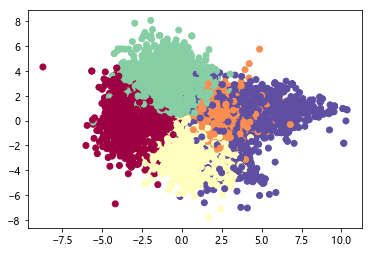

In [17]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA

labels = kmean.labels_
centers = kmean.cluster_centers_
X_plot = np.array(X_sentences)
pca = PCA(n_components=2)   #降到2维
pca.fit(X_plot)                  #训练
newX=pca.fit_transform(X_plot)   #降维后的数据

fig = plt.figure()
# ax = fig.gca(projection='3d')
ax = fig.gca()
ax.scatter(newX[:, 0], newX[:, 1], c=labels, cmap=plt.cm.Spectral)
plt.show()

In [18]:
# 测试一下，输入句子属于哪一类
input = '你好'
x_quest = cs.segment(input,'arr')
x_vec = sum([model.wv[word] for word in x_quest])/len(x_quest)

print('class: ',kmean.predict([x_vec]))


class:  [4]


In [19]:
joblib.dump(kmean , 'km.pkl')

['km.pkl']

## 语义相似度判断

In [ ]:
kmean = joblib.load('km.pkl')
print(kmean.labels_)

In [20]:
def get_class(model,sentence):
    return model.predict([vectorize(sentence)])

In [22]:
from sklearn.neighbors import KDTree

class DataSpace():
    def __init__(self,classes_data):
        '''
        构建KD树
        '''
        points = len(classes_data)
        leaf = points/2-1
        self.tree = KDTree(classes_data,leaf)
        
    def __vectorize__(self,sentence):
        x_quest = cs.segment(sentence,'arr')
        return [sum([model.wv[word] for word in x_quest])/len(x_quest)]
    
    def similarity(self,sentence,topk=10):
        '''
        从KD树中找到最相似的k个数据
        '''
        v = self.__vectorize__(sentence)
        dist, ind = self.tree.query(v,k=topk)
        return (dist,ind)
    
    def save(self,filename):
        pass

In [23]:
data0 = DataSpace(np.array(X_sentences)[kmean.labels_==0])
sentence1 = np.array(new_sentences)[kmean.labels_==0]
data1 = DataSpace(np.array(X_sentences)[kmean.labels_==1])
sentence2 = np.array(new_sentences)[kmean.labels_==1]
data2 = DataSpace(np.array(X_sentences)[kmean.labels_==2])
sentence3 = np.array(new_sentences)[kmean.labels_==2]
data3 = DataSpace(np.array(X_sentences)[kmean.labels_==3])
sentence4 = np.array(new_sentences)[kmean.labels_==3]
data4 = DataSpace(np.array(X_sentences)[kmean.labels_==4])
sentence5 = np.array(new_sentences)[kmean.labels_==4]

In [24]:
_,ind = data2.similarity('你好')
sentence3[ind]

array([[list(['索', '小粒', '我', '的', '麻麻', '呀']), list(['是', '呀', '谢谢']),
        list(['真', '听话']),
        list(['嘿嘿', '必须', '的', '我', '这么', '可爱', '的', '~']),
        list(['就是', '主人', '你好', '聪明', '啊', '么', '么']),
        list(['比', '你', '高', '啦']), list(['你妹', '呀', '的']),
        list(['那', '是因为', '主人', '你', '更', '可爱', '呀']),
        list(['哈哈', '你妹']), list(['真', '他妈的', '贱'])]], dtype=object)

## 布尔搜索

In [25]:
import json

#建立词汇-文档表
class BoolSearch():
    def __init__(self,docs=None):
        if docs==None: return
        self.words={}
        #二进制位数
        self.bits = len(docs)
        self.keys = set()
        for indx in tqdm(range(self.bits)):
            for word in docs[indx]: self.keys.add(word)
                    
        for word in tqdm(self.keys):
            for indx in range(self.bits):
                if word not in self.words: self.words[word]=0
                self.words[word] <<= 1
                if word in docs[indx]:
                    self.words[word] |= 1
#         print(self.words)

    def __itr_dict__(self,doc):
        # 1.先遍历词典,判断词典中的词是否在新文档中
        for word in self.words.keys():
        # 2.如果在文档中
            self.words[word] <<= 1
            if word in doc:
        # 3.就向左移位并加一
                self.words[word] |= 1
        # 4.否则只向左移位
        # 5.然后从文档中移除这个词
                while word in doc: doc.remove(word)
                
    def __itr_doc__(self,doc):
        # 6.接着遍历文档中剩下的词,重复步骤3
        for word in doc:
            self.words[word] = 0
            self.words[word] <<= 1
            self.words[word] |= 1
                    
    def __all__(self,n):
        num = 1
        for i in range(n-1):
            num <<=1
            num |= 1
        return num
    
    def search(self,input):
        result = self.__all__(self.bits)
#         print(self.bits,result)
        for word in input:
            if not self.words.__contains__(word): continue
            result &= self.words[word]
        return result
    
    def show(self):
        print(self.words)
        
    def get_indexes(self,input):
        result = self.search(input)
        indexes = []
        for indx in range(self.bits):
            if result & 1: indexes.append(self.bits-indx -1)
            result >>=1
        return indexes
    
    def save(self,filepath):
        with open(filepath, 'w') as fw:
            json.dump({'bits':self.bits,'words':self.words},fw)
        
    def load(self,filepath):
        with open(filepath,'r') as f:
            s = json.load(f)
            self.bits = s['bits']
            self.words = s['words']

In [26]:
bool_search = BoolSearch(all_questions)

100%|██████████████████████████████████████████████████████████████████████████| 39362/39362 [1:42:38<00:00,  6.39it/s]


In [27]:
bool_search.save('search_answer.jsn')